# DSC 180A Checkpoint

## Import packages & Data

In [466]:
import numpy as np
import pandas as pd
import matplotlib.pyplot
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict
import string
import math
import nltk
import emoji
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error

In [467]:
# read in data
data = pd.read_csv("SentimentLabeled_10112022.csv")
data.head()

,date,text,userid_str,status_id_str,id,name,birth,term_partisanship,term_type,term_state,country,Bucket,SentimentScore,version
0,2015-09-28,I commend all of law enforcement for the secur...,156333623.0,6.485341e+17,3517566,Al Green,1947-09-01,Democrat,rep,TX,China,2 or 3,NaN,2019_batch1
1,2019-02-24,"Socialist tyrant Maduro starves, tortures his ...",235312723.0,1.099734e+18,3559992,Scott DesJarlais,1964-02-21,Republican,rep,TN,China,1,2.0,2019_batch1
2,2019-02-24,"Socialist tyrant Maduro starves, tortures his ...",235312723.0,1.099734e+18,3559992,Scott DesJarlais,1964-02-21,Republican,rep,TN,Iran,2 or 3,NaN,2019_batch1
3,2014-06-24,Inhofe: The Canadians have already had convers...,20546536.0,4.815273e+17,3468157,James M. Inhofe,1934-11-17,Republican,sen,OK,Canada,2 or 3,NaN,2019_batch1
4,2015-07-14,Statement on Iran nuclear agreement. http://t....,18773159.0,6.210401e+17,3833428,Scott Perry,1962-05-27,Republican,rep,PA,Iran,2 or 3,NaN,2019_batch1


In [468]:
data.shape

(15846, 14)

In [469]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15846 entries, 0 to 15845
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               15846 non-null  object 
 1   text               15846 non-null  object 
 2   userid_str         15642 non-null  float64
 3   status_id_str      8074 non-null   float64
 4   id                 15846 non-null  int64  
 5   name               15846 non-null  object 
 6   birth              15642 non-null  object 
 7   term_partisanship  15642 non-null  object 
 8   term_type          15846 non-null  object 
 9   term_state         15846 non-null  object 
 10  country            15846 non-null  object 
 11  Bucket             14614 non-null  object 
 12  SentimentScore     12259 non-null  float64
 13  version            15642 non-null  object 
dtypes: float64(3), int64(1), object(10)
memory usage: 1.7+ MB


In [470]:
data.isna().sum()

date                    0
text                    0
userid_str            204
status_id_str        7772
id                      0
name                    0
birth                 204
term_partisanship     204
term_type               0
term_state              0
country                 0
Bucket               1232
SentimentScore       3587
version               204
dtype: int64

## Data Cleaning

In [471]:
data.Bucket.value_counts()

1         10797
2 or 3     3344
2           292
1.0         122
3            48
2.0          10
3.0           1
Name: Bucket, dtype: int64

In [472]:
# drop the duplicate data 
data.drop_duplicates(inplace=True)
data.shape

(15509, 14)

In [473]:
# helper functions for data cleaning
def clean_buckets(bucket_num):
    if bucket_num == "1" or bucket_num == "1.0":
        return "A" # bucket1
    else:
        return "B" # non-bucket1

In [474]:
# cleaning & wrangling

# uniform data format
data["term_partisanship"] = data["term_partisanship"].str.strip("{}")
data["term_type"] = data["term_type"].str.strip("{}")
data["term_state"] = data["term_state"].str.strip("{}")

# feature engineering
data['text_length'] = data['text'].apply(lambda x: len(x.split()))
data['cleaned_buckets'] = data['Bucket'].apply(clean_buckets)
data[['date','birth']] = data[['date','birth']].apply(pd.to_datetime)

# filtering abnormal data
#data = data[data['SentimentScore'] <= 5]
data.reset_index(drop=True, inplace=True)

In [475]:
data.Bucket.value_counts()

1         10564
2 or 3     3248
2           288
1.0         122
3            47
2.0          10
3.0           1
Name: Bucket, dtype: int64

In [476]:
data.cleaned_buckets.value_counts()

A    10686
B     4823
Name: cleaned_buckets, dtype: int64

In [489]:
data.SentimentScore.value_counts().sum()

12018

In [477]:
# data after cleaning
print(data.shape)
data.head()

(15509, 16)


,date,text,userid_str,status_id_str,id,name,birth,term_partisanship,term_type,term_state,country,Bucket,SentimentScore,version,text_length,cleaned_buckets
0,2015-09-28,I commend all of law enforcement for the secur...,156333623.0,6.485341e+17,3517566,Al Green,1947-09-01,Democrat,rep,TX,China,2 or 3,NaN,2019_batch1,22,B
1,2019-02-24,"Socialist tyrant Maduro starves, tortures his ...",235312723.0,1.099734e+18,3559992,Scott DesJarlais,1964-02-21,Republican,rep,TN,China,1,2.0,2019_batch1,44,A
2,2019-02-24,"Socialist tyrant Maduro starves, tortures his ...",235312723.0,1.099734e+18,3559992,Scott DesJarlais,1964-02-21,Republican,rep,TN,Iran,2 or 3,NaN,2019_batch1,44,B
3,2014-06-24,Inhofe: The Canadians have already had convers...,20546536.0,4.815273e+17,3468157,James M. Inhofe,1934-11-17,Republican,sen,OK,Canada,2 or 3,NaN,2019_batch1,23,B
4,2015-07-14,Statement on Iran nuclear agreement. http://t....,18773159.0,6.210401e+17,3833428,Scott Perry,1962-05-27,Republican,rep,PA,Iran,2 or 3,NaN,2019_batch1,6,B


## Exploratory Data Analysis

In [478]:
data.term_partisanship.value_counts()

Republican     11131
Democrat        4066
Independent      108
Name: term_partisanship, dtype: int64

In [480]:
data.shape

(15509, 16)

<AxesSubplot:xlabel='term_partisanship', ylabel='count'>

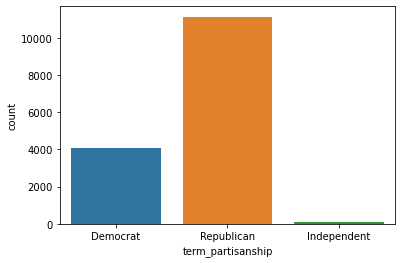

In [365]:
sns.countplot(data.term_partisanship)

<AxesSubplot:xlabel='country', ylabel='count'>

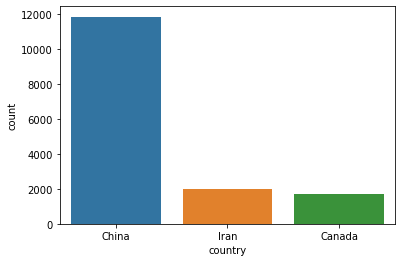

In [366]:
sns.countplot(data.country)

<AxesSubplot:xlabel='Bucket', ylabel='count'>

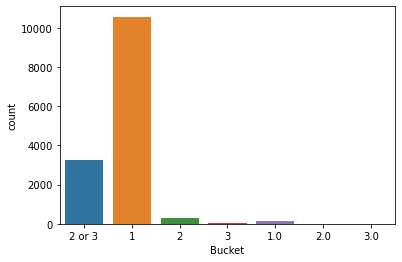

In [487]:
sns.countplot(data.Bucket)

<AxesSubplot:xlabel='SentimentScore', ylabel='Density'>

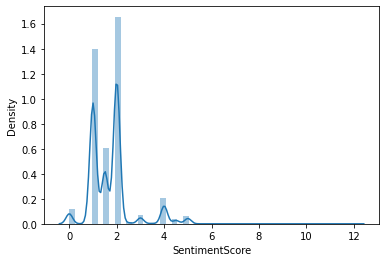

In [367]:
sns.distplot(data.SentimentScore)

<AxesSubplot:>

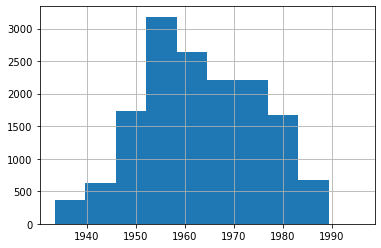

In [368]:
pd.to_datetime(data.birth).hist()

<AxesSubplot:>

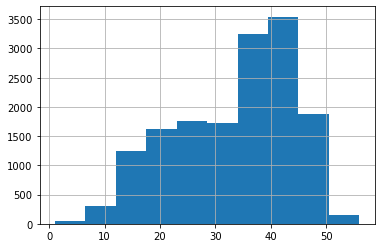

In [369]:
data['text_length'].hist()

## Modeling

### Text Preprocessing

In [382]:
# select China-related tweets only
df = data[data['country']=='China']
df.cleaned_buckets.value_counts()

A    8719
B    3130
Name: cleaned_buckets, dtype: int64

In [383]:
# peek at the raw text
df.text

0        I commend all of law enforcement for the secur...
1        Socialist tyrant Maduro starves, tortures his ...
7        Russia, China, India, Pakistan, North Korea, I...
10       Ileana Ros-Lehtinen, Ted Yoho Condemn China's ...
12       Inhofe: So if the oil doesn’t come to the Unit...
                               ...                        
15504    Is it fair to make the assessment that China h...
15505    American citizen @BobFu4China, who has been a ...
15506    The inclusion of those products in #GSP would ...
15507    Join me THURSDAY at 9:00 AM CT on Facebook LIV...
15508    The Commitment to American GROWTH Act is a key...
Name: text, Length: 11849, dtype: object

In [384]:
# function for text cleaning
def process_text(text):
    # if is Nan
    if type(text)==np.float: 
        return ""
    
    # uniform format
    temp = text.lower().replace("\n","")
    # remove hyperlinks
    temp = ' '.join([x for x in temp.split() if not ('http' in x or 'www' in x)]).split()

    # filtering characters
    special_chars = list("~!@#$%^&*()_+-={}[]\|<>?.,;:`") # special characters
    res = []
    for word in temp:
        for i in special_chars:
            word = word.replace(i,'')
        res.append(word)

    # remove stopwords
    sw = stopwords.words('english')                   # english stopwords
    res = [i for i in res if x not in sw]

    return " ".join(res)

In [385]:
df["cleaned_text"] = df['text'].apply(lambda x: process_text(x))

### Relevance Bucket Predicting (Classification)

In [386]:
# filter out irrelevant data
df_bkt = df[['cleaned_text', 'cleaned_buckets']]
df_bkt.drop_duplicates(inplace=True, ignore_index=True)
df_bkt.head()

,cleaned_text,cleaned_buckets
0,i commend all of law enforcement for the secur...,B
1,socialist tyrant maduro starves tortures his p...,A
2,russia china india pakistan north korea iran a...,A
3,ileana roslehtinen ted yoho condemn china's tr...,A
4,inhofe so if the oil doesn’t come to the unite...,B


In [387]:
df_bkt.cleaned_buckets.value_counts()

A    8077
B    3014
Name: cleaned_buckets, dtype: int64

In [388]:
# balance class
df_bkt_A = df_bkt[df_bkt.cleaned_buckets=='A']
df_bkt_B = df_bkt[df_bkt.cleaned_buckets=='B']

df_bkt_A_sample = resample(df_bkt_A, replace=False, n_samples=3000, random_state=0)
df_bkt_B_sample = resample(df_bkt_B, replace=False, n_samples=3000, random_state=0)
df_bkt_final = pd.concat([df_bkt_A_sample, df_bkt_B_sample])
df_bkt_final.shape

(6000, 2)

In [389]:
df_bkt_final.head()

,cleaned_text,cleaned_buckets
7867,big policy victory 👀sen rubio secured a provis...,A
10150,here’s where senate gop stand✔️ prochina✔️ pro...,A
2732,great to be on with trish regan talking about ...,A
4425,as beijingbacked forces cross violent new thre...,A
6002,if we don't fully embrace the nuclear renaissa...,A


In [390]:
# split data
X = df_bkt_final.cleaned_text.to_frame()
y = df_bkt_final.cleaned_buckets.to_frame()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [421]:
def model_1(X_train, y_train):
    preprocessor = ColumnTransformer(
        transformers=[
            ("bog", CountVectorizer(), 'cleaned_text'),]
            #("tfidf", TfidfVectorizer(), 'cleaned_text')]
    )

    clf = SVC(random_state=0)
    #clf = RandomForestClassifier()

    pl = Pipeline([
                    ('preprocessor', preprocessor),
                    ('clf', OneVsRestClassifier(clf, n_jobs=1)),
                ])

    pl.fit(X_train, y_train)
    return pl

In [422]:
pl = model_1(X_train, y_train)
preds = pl.predict(X_test)

In [423]:
print('Accuracy:  ' + str(accuracy_score(y_test, preds)))
print('Confusion Matrix: \n' + str(confusion_matrix(y_test, preds)))
res = precision_recall_fscore_support(y_test, preds,average='binary',pos_label='A')
print('Precision: ' + str(res[0]))
print('Recall:    ' + str(res[1]))
print('F1 score:  ' + str(res[2]))

Accuracy:  0.7083333333333334
Confusion Matrix: 
[[457 156]
 [194 393]]
Precision: 0.7019969278033794
Recall:    0.7455138662316476
F1 score:  0.7231012658227849


### Sentiment Score Predicting (Regression)

In [459]:
# filter out irrelevant data
df_ss = df[['cleaned_text', 'SentimentScore']]
df_ss.drop_duplicates(inplace=True, ignore_index=True)
df_ss.dropna(inplace=True)
df_ss = df_ss[df_ss['SentimentScore']<=5]
df_ss['SentimentScore'] = df_ss['SentimentScore'].astype(float)
df_ss.head()

,cleaned_text,SentimentScore
1,socialist tyrant maduro starves tortures his p...,2.0
2,russia china india pakistan north korea iran a...,2.0
3,ileana roslehtinen ted yoho condemn china's tr...,1.5
5,breaking in oval office meeting today the chin...,4.5
6,breaking in oval office meeting today the chin...,4.0


In [455]:
df_ss.shape

(9187, 2)

In [461]:
# split data
X = df_ss.cleaned_text.to_frame()
y = df_ss.SentimentScore.to_frame()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [464]:
def model_2(X_train, y_train):
    preprocessor = ColumnTransformer(
        transformers=[
            ("bog", CountVectorizer(), 'cleaned_text'),
            ("tfidf", TfidfVectorizer(), 'cleaned_text')]
    )

    #reg = GradientBoostingRegressor()
    reg = LGBMRegressor()
    #reg = ElasticNet()

    pl = Pipeline([
                    ('preprocessor', preprocessor),
                    ('reg', reg),
                ])

    pl.fit(X_train, y_train)
    return pl

In [465]:
pl = model_2(X_train, y_train)
preds = pl.predict(X_test)
print('MSE:  ' + str(mean_squared_error(y_test, preds)))

MSE:  0.27701139340384334
